Here, we will look at the time series. These are observations series who distinguish themselves of the usual data for traditionnal machine learning problems to the fact that there is only one single explicative variable : The time. The aim of this kernel is to find out more about the time series analysis, and then predict futur evolution (futur sales here).

There are widespread time series practical examples indeed so it's wise to practice this domain.

Some of these examples are :

- Economics (unemployment, growth, trading price..)
- Environment (pressure, temperature, consumption of electricity ..)
- Health (sugar level, electrocardiogram..)

We distinguish three main axes with time series : Visualization, analysis and forecast. Through these three axes, it's clear that the time series have their own place in the Data Science for the reason that the issues are the same than for all the Data Science issues.

    
## Competition and data overview:

In this playground competition, we are provided with the challenge of predicting sales in the next month for Russian Software company-[1c company](http://1c.ru/eng/title.htm). 

**What does the IC company do?:**

1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.

**Data**:
We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.

## Imports:

In [6]:
#python3.6 -m pip install scipy==1.2 --upgrade

# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
#import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
#import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Import all of the data
sales=pd.read_csv("sales_train_v2.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("item_categories.csv")
item=pd.read_csv("items.csv")
sub=pd.read_csv("sample_submission.csv")
shops=pd.read_csv("shops.csv")
test=pd.read_csv("test.csv")

In [145]:
print('train:', sales.shape, 'test:', test.shape)
print('items:', item.shape, 'item_cats:', item_cat.shape, 'shops:', shops.shape)

train: (2935849, 6) test: (214200, 3)
items: (22170, 3) item_cats: (84, 2) shops: (60, 2)


In [11]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [147]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [146]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [148]:
sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [149]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [13]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


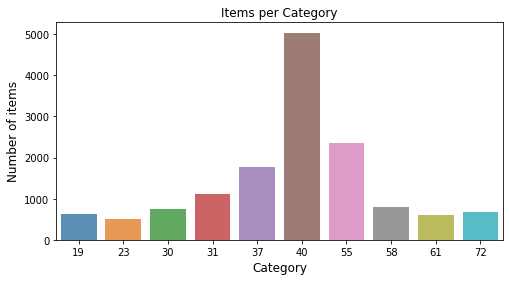

In [16]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('Number of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

Of course, there is a lot more that we can explore in this dataset, but here I will focus on the time-series part.

## Time series

The objective requires us to predict sales for the next month at a store-item combination. But I will focus my work forecast a single series for now.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

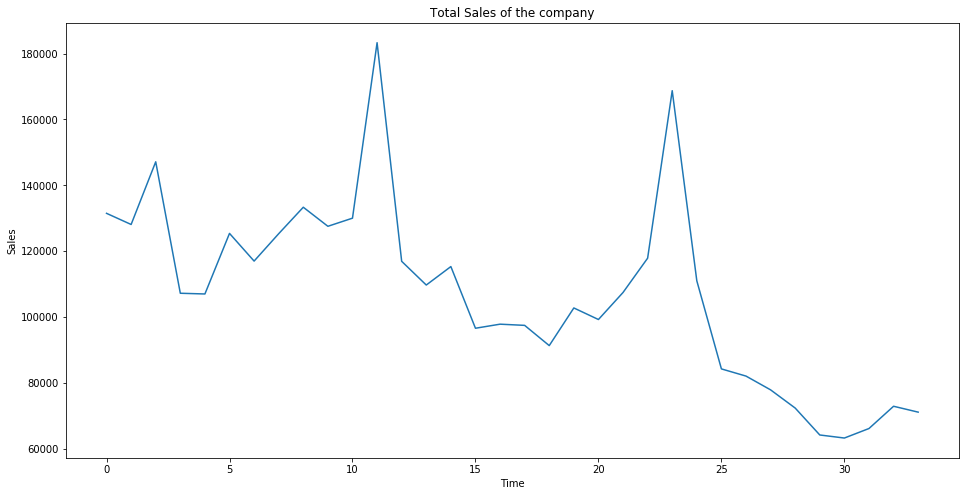

In [17]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

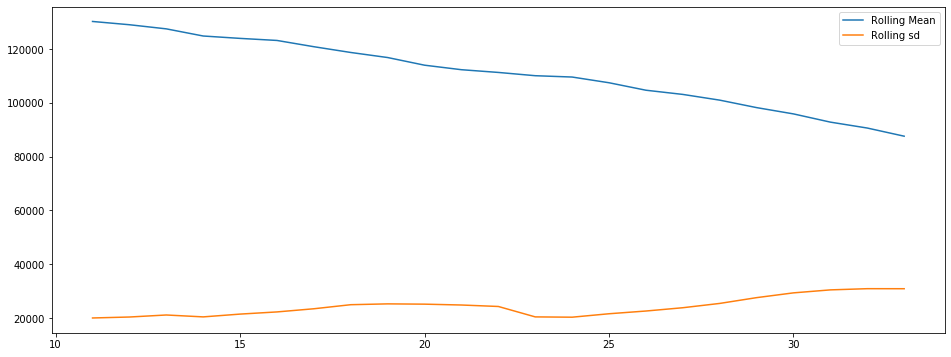

In [20]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**Quick observations**

- We grouped our sales by month : January 2013 is 0, February 2013 is 1,..., October 2015 is 33.
- We can see a seasonality for some months, there's obvously some major peaks (11,23...), so maybe a 12 month seasonality ?
- We can see a decreasing trend, the mean continuously decreasing.

In raw form, time serie give us very limited informations. Like I said above, trend drecreasing with time, but because of the seasonality, this decrease is hard to to quantify.

We could say than three components make a time series : 

- **Trend**
- **Seasonality**
- **Residual**

These three components may be combined in two distinct models : the additive model or the multiplicative model.

In the additive model, we consider that the time series (Xt) is the result of the sum of these three components :

> Xt=Tt+St+ϵt

where Xt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period t and ϵt is the reminder (or irregular or error) component at period t. 

Similarly for Multiplicative model :


> Xt=Tt(1+St)(1+ϵt)

We are going to use the statsmodels pakckage to analyse our time series and decide which model to pick up.

First of all, let's try the *multiplicative* model :

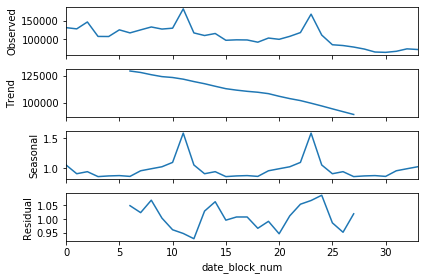

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(ts,freq=12,model="multiplicative")

res.plot()
plt.show();

Then the *additive* model :

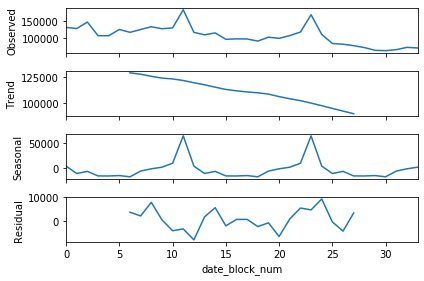

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(ts,freq=12,model="additive")

res.plot()
plt.show();

Given the residual, we assume an **additive model**. Now let's visualize the **stationnarity**, but first :

![q](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

Stationarity refers to time-invariance of a series. Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

A time series need to be stationary so that it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.


There are multiple tests that can be used to check stationarity :

- ADF( Augmented Dicky Fuller Test) 
- KPSS 
- PP (Phillips-Perron test)

Let's just perform the ADF which is the most commonly used one.

In [32]:
from statsmodels.tsa.stattools import adfuller

pd.DataFrame(adfuller(ts)[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Values'])

,Values
Test Statistic,-2.395704
p-value,0.142953
#Lags Used,0.000000
Number of Observations Used,33.000000


We obtained a **p-value** > 0.05, so we cannot reject the H0 hypothesis, our series is not stationary ! We need to fix that. Let's visualize our series after :
> a differenciation (to perform a de-trend)

> a differenciation with seasonality (to perform a de-seasonalization)

We assuming the seasonality is 12 months long

[]

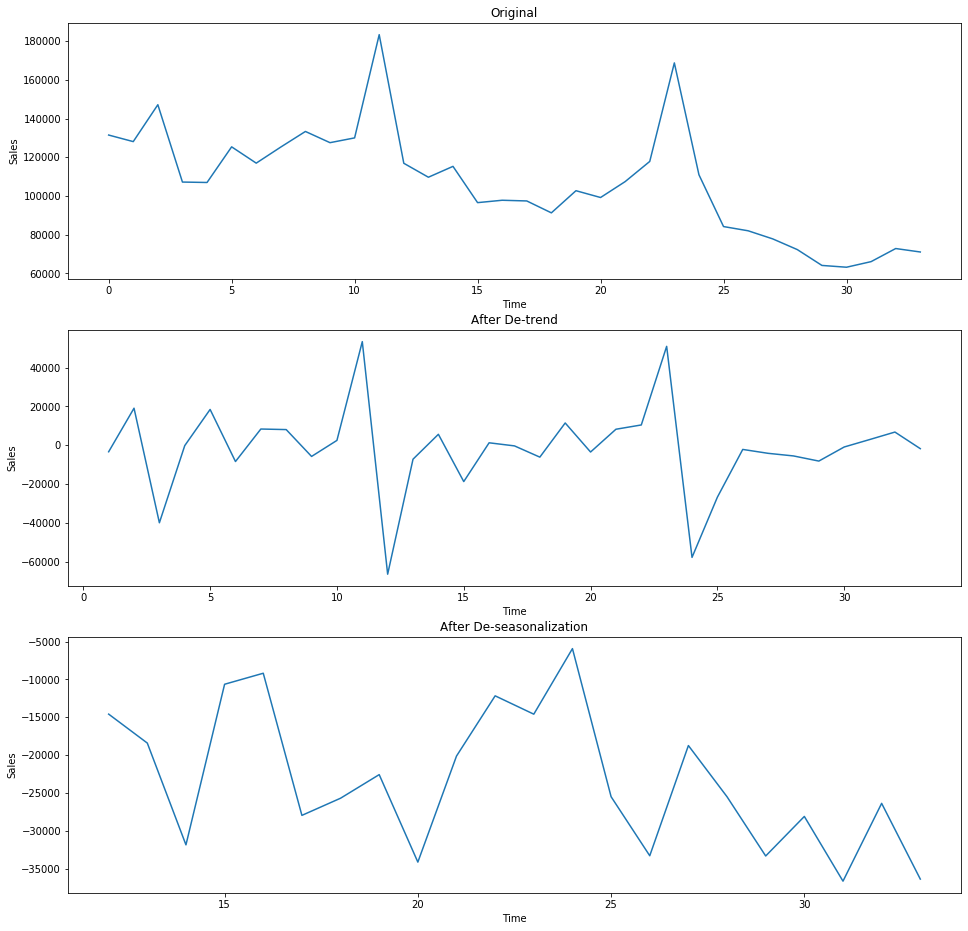

In [88]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')


plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts= ts.diff().dropna()
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts= ts.diff(periods = 12).dropna()      
plt.plot(new_ts)
plt.plot()

We can also visualise this with autocorrelation_plot. Indeed, regardless the process, the simple autocorrelation must decline over 0 quite fast if the process is stationary ! Let's visualise our initial time series without differenciation :

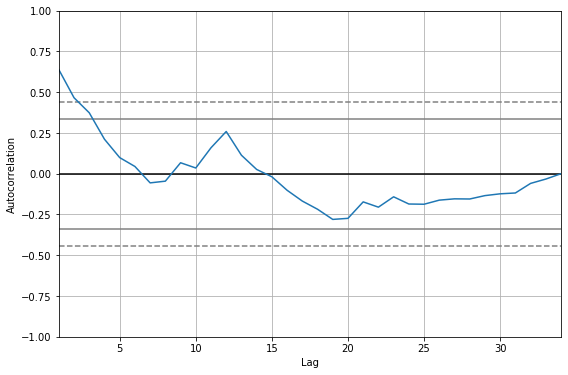

In [165]:
from pandas.plotting import autocorrelation_plot

ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

plt.figure(figsize=(9,6))
autocorrelation_plot(ts)
plt.plot();

We cal clearly see that our autocorrelation function is slowly decreasing, hence our time series isn't stationary yet.
Let's see after our differenciation.

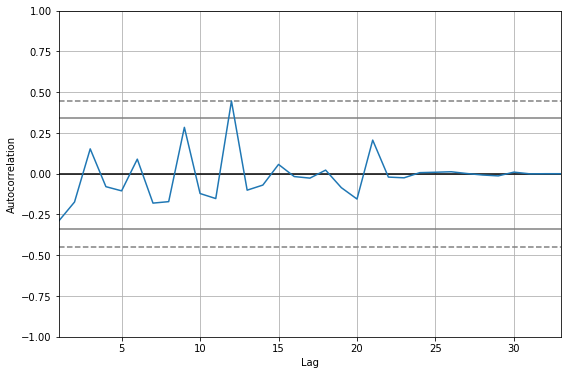

In [166]:
plt.figure(figsize=(9,6))
new_ts= ts.diff().dropna()
autocorrelation_plot(new_ts)
plt.plot();


This time our simple autocorrelation seem to tend over 0 quite fast but present some serious seasonal peaks. let's differientate with seasonality to eliminate her.

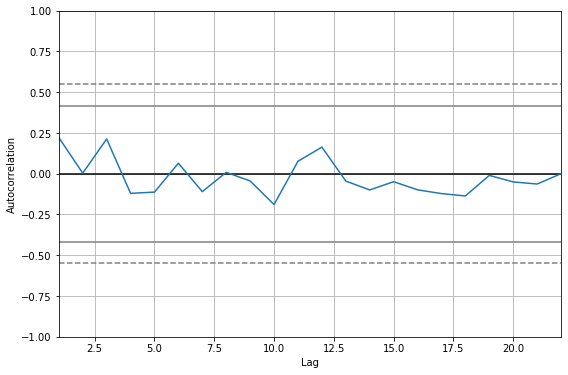

In [169]:
plt.figure(figsize=(9,6))
new_ts= ts.diff(periods = 12).dropna()      
autocorrelation_plot(new_ts)
plt.plot();

This time, it's seems that our time series is stationary, let's test that with the Augmented Dicky Fuller Test.

In [170]:
pd.DataFrame(adfuller(new_ts)[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Values'])

,Values
Test Statistic,-3.270101
p-value,0.016269
#Lags Used,0.000000
Number of Observations Used,21.000000


Our **p-value** is < 0.05, hence we can assume the **stationarity** of the series.

Now let's dive into making the forecasts. But first, we need to find our best parameter P,Q, p and q to determine which SARIMA(p,d,q)(P,D,Q) process could modelling our time serie in such a way as to best accomplish our purposes. For this, there are some methods. We will use our theorics knowledges and statsmodels to do that. We already determined d and D (1,1) with our differenciation !

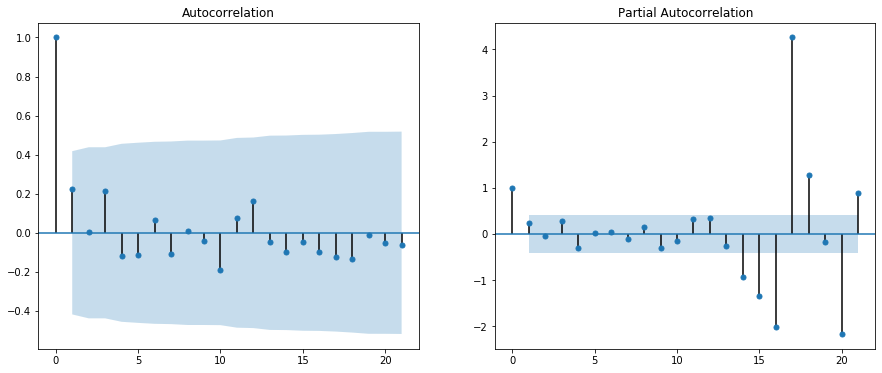

In [76]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


plt.figure(figsize = (15,6))
plt.subplot(121)
plot_acf(new_ts, ax = plt.gca())
plt.subplot(122)
plot_pacf(new_ts, ax = plt.gca())
plt.show()

With the help of ACF and PACF, we can determine :

- p = 0, q = 0 (we can see than the blue-ish area of the ACF and PACF is cancelled after then rank 1)
- Q = 0
- P = 0

We probably have a model of the type *SARIMA⁡(0,1,0)(0,1,0)12*. Let's see :

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

m = SARIMAX(ts, order=(0,1,0), seasonal_order = (0,1,0,12))

m_fitted = m.fit()

print(m_fitted.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       item_cnt_day   No. Observations:                   34
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -225.299
Date:                            Mon, 18 Nov 2019   AIC                            452.598
Time:                                    16:26:03   BIC                            453.643
Sample:                                         0   HQIC                           452.825
                                             - 34                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.147e+08   4.49e+07      2.555      0.011    2.67e+07    2.03e+08
Ljung-Box (Q):                     

The Jarque-Bera test is a statistical test aiming to reject (or not) the H0 hypothesis : The residual follow a normal distribution. 
Here, we can read on the line Prob(JB) than the p-value is 0.69, we accept the hypothesis. 

The residual seems quite good, our SARIMA model seems to be appropriate.

So, now we will use this model to make predictions.

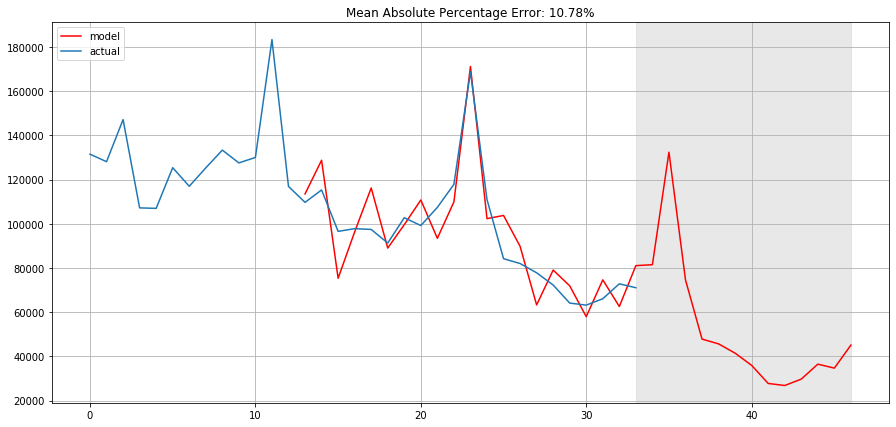

In [103]:
ts = pd.DataFrame(ts)

p = 0
d = 1 
q = 0
P = 0
D = 1 
Q = 0
s = 12

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    #plt.plot(forecast[-n_steps-2:], color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
plotSARIMA(ts, m_fitted, 12)

It seems our model have captured the trend and the seasonality but it could be better. The model line doesn't follow extremely well our actual line. It seems that our SARIMA model had captured too much seasonality. The decreasing trend seems to be captured and the major peak seasonality too so that not so bad ! Let's see with Prophet.

### **Prophet** :

Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy.

In [135]:
#https://anaconda.org/conda-forge/fbprophet

from fbprophet import Prophet

ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()

# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()


#prophet requires a date column named as DS and the value column as Y
ts.columns=['ds','y']

model = Prophet(seasonality_mode='additive', daily_seasonality = False, weekly_seasonality = False )

ts = ts.rename(columns={"date_block_num": "ds", "item_cnt_day": "y"})

model.fit(ts)

In [140]:
future = model.make_future_dataframe(periods=12, freq = 'MS')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
41,2016-06-01,38673.613335,35194.363598,42090.316460
42,2016-07-01,23236.805000,19827.548807,26567.743929
43,2016-08-01,34354.104154,30525.026421,37752.591849
44,2016-09-01,38214.609434,34604.150669,42117.882853
45,2016-10-01,33905.676541,30070.018223,37942.246520


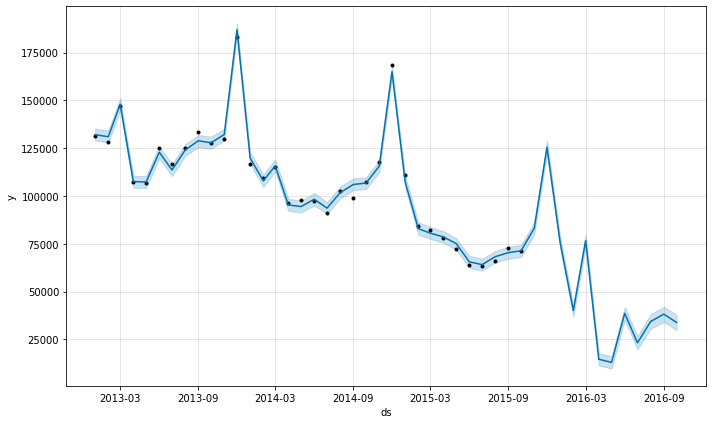

In [139]:
fig = model.plot(forecast)

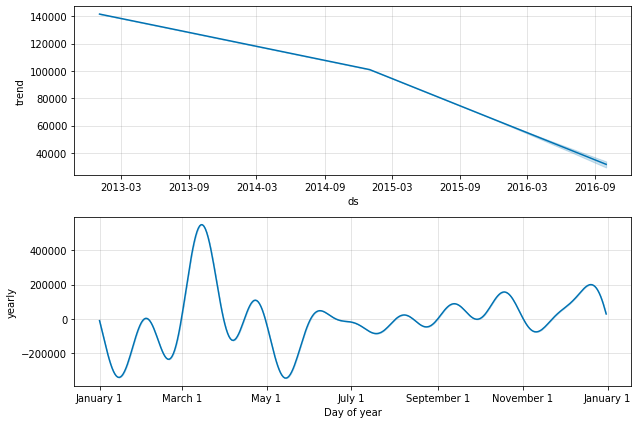

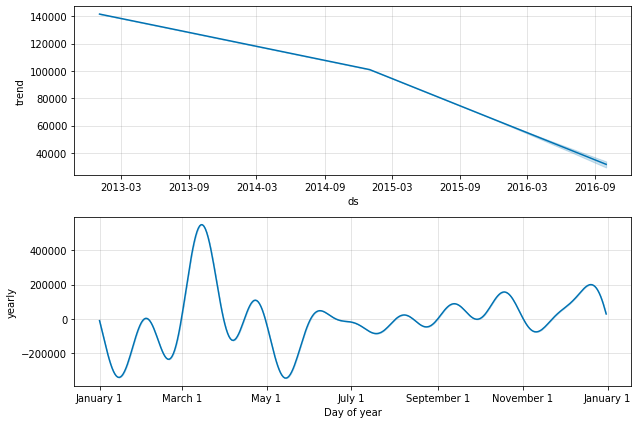

In [141]:
model.plot_components(forecast)

Awesome. The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.

And here we are, we have seen how to built a SARIMA model with a time series and how to build predictions from this model and with the new Facebook tool : Prophet. 

*That's just the basics concepts but I wanted to do a little project based on time series to remind me the fundamentals !*

I will certainly update this kernel later, they are so much more about time series thaht I haven't had time to develop.

See you later !